In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from zlib import crc32
from copy import deepcopy

from tqdm import tqdm

In [2]:
from zlib import crc32

theory = crc32('Фельдман'.lower().encode('utf-8'))%5+1
practice = crc32('Feldman'.lower().encode('utf-8'))%3+1
theory, practice

(1, 2)

In [3]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
trainset = datasets.MNIST('./data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST('./data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [24]:
class LogReg(nn.Module):
    
    def __init__(self, features = 784, classes=10):
        super(LogReg, self).__init__()
        
        self.features = features
        self.classes = classes
        
        self.loc = nn.Parameter(torch.randn(features * classes))
        self.disp = nn.Parameter(torch.abs(torch.randn(features * classes)))
        self.dist = torch.distributions.MultivariateNormal(torch.zeros(self.features*self.classes), precision_matrix=torch.eye(self.features*self.classes))
        
    def forward(self, x):
        x = x.view(-1, self.features)       
        z = self.dist.sample().to(device)
        w = self.loc + self.disp * z
        res = torch.mm(x, w.view(self.features, self.classes))
        return res
    
    def loc_value(self, x):
        x = x.view(-1, self.features)
        res = torch.mm(x, self.loc.view(self.features, self.classes))
        return res

In [11]:
device = 'cpu'
model = LogReg().to(device)

In [46]:
crossentropy = nn.CrossEntropyLoss(reduction='sum')

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

for data, target in tqdm(train_loader):
    data, target = data.to(device), target.to(device)
    
    optimizer.zero_grad()
    cross = crossentropy(model(data), target)
    kl_div = 0.5 * (torch.sum(model.disp) + torch.sum(model.loc * model.loc) - torch.sum(torch.log(model.disp)))
    loss = cross + kl_div
    
    loss.backward()
    optimizer.step()

100%|██████████| 1875/1875 [01:00<00:00, 31.00it/s]


In [20]:
print(loss)

tensor(6333.6719, grad_fn=<AddBackward0>)


In [14]:
def prune_params(params, lam):
    var_params = deepcopy(params)
    rand_params = deepcopy(params)
    
    lambdas = torch.abs(params['loc']/params['disp'])
    mask = (lambdas < lam)
    var_params['loc'][mask] = 0
    
    pruned = mask.sum().float()/mask.shape[0]
    
    mask = mask.view(-1)[torch.randperm(mask.nelement())].view(mask.size())
    rand_params['loc'][mask] = 0
    
    return var_params, rand_params, pruned

In [15]:
source_params = deepcopy(model.state_dict())

In [16]:
import numpy as np

In [26]:
def accuracy(loader, model):
    correct = 0
    total = 0
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = torch.argmax(model.loc_value(data), dim=-1)
        correct += (output == target).float().sum()
        total += len(output)
        
    return correct/total

In [44]:
x = (np.exp(np.linspace(0, 15, 14)) - 1)/1e4
var_accs = []
rand_accs = []
pruned = []
for lam in tqdm(x):
    pruned_params, rand_parms,  deleted = prune_params(source_params, lam)
    pruned.append(deleted)
    
    model.load_state_dict(pruned_params)
    model.eval()
    var_accs.append(accuracy(test_loader, model))
    
    model.load_state_dict(rand_parms)
    model.eval()
    rand_accs.append(accuracy(test_loader, model))

100%|██████████| 14/14 [00:39<00:00,  2.80s/it]


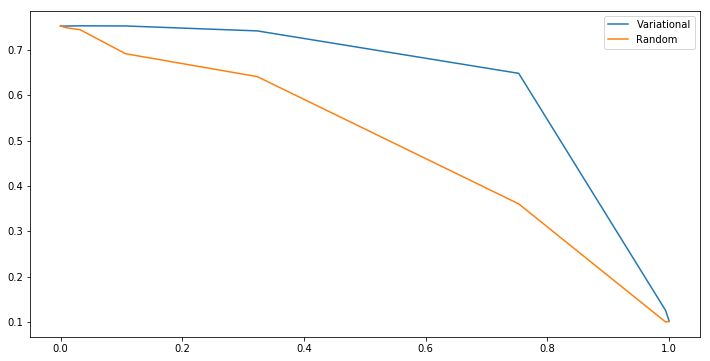

In [45]:
plt.figure(figsize = (12,6))
plt.plot(pruned, var_accs, label='Variational')
plt.plot(pruned, rand_accs, label='Random')
plt.legend()
plt.show()

### Выводы:

В результате эксперимента мы убедились, что баессовский подход при удалении неинформативных параметров работает лучше, чем случайное. При разреженности около 0.7 баессовский подход дает почти такую же точность, что и неразреженная модель, чего нельзя сказать о модели со случайным удалением параметров, точность которой падает практически линейно.